In [7]:
# coding: utf-8
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor


class GPUCB(object):

  def __init__(self, meshgrid, environment, beta=100.):
    '''
    meshgrid: Output from np.methgrid.
    e.g. np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1)) for 2D space
    with |x_i| < 1 constraint.
    environment: Environment class which is equipped with sample() method to
    return observed value.
    beta (optional): Hyper-parameter to tune the exploration-exploitation
    balance. If beta is large, it emphasizes the variance of the unexplored
    solution solution (i.e. larger curiosity)
    '''
    self.meshgrid = np.array(meshgrid)
    self.environment = environment
    self.beta = beta

    self.X_grid = self.meshgrid.reshape(self.meshgrid.shape[0], -1).T
    self.mu = np.array([0. for _ in range(self.X_grid.shape[0])])
    self.sigma = np.array([0.5 for _ in range(self.X_grid.shape[0])])
    self.X = []
    self.T = []

  def argmax_ucb(self):
    return np.argmax(self.mu + self.sigma * np.sqrt(self.beta))

  def learn(self):
    grid_idx = self.argmax_ucb()
    self.sample(self.X_grid[grid_idx])
    gp = GaussianProcessRegressor()
    gp.fit(self.X, self.T)
    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)

  def sample(self, x):
    t = self.environment.sample(x)
    self.X.append(x)
    self.T.append(t)

  def plot(self):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.mu.reshape(self.meshgrid[0].shape), alpha=0.5, color='g')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.environment.sample(self.meshgrid), alpha=0.5, color='b')
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
        marker='o', alpha=1.0)
    plt.savefig('fig_%02d.png' % len(self.X))




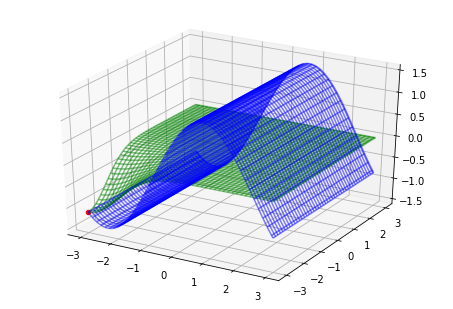

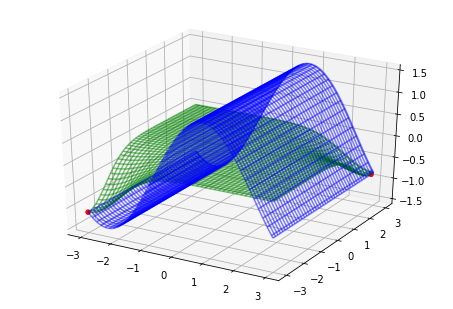

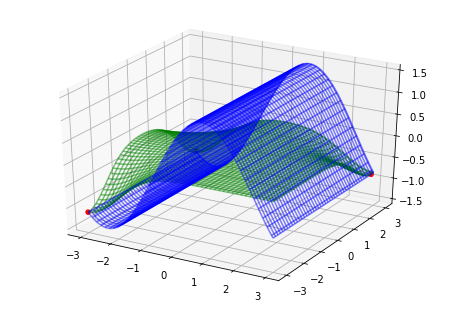

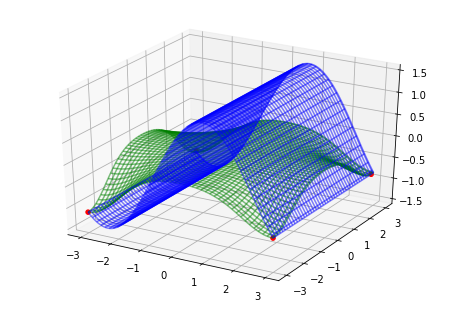

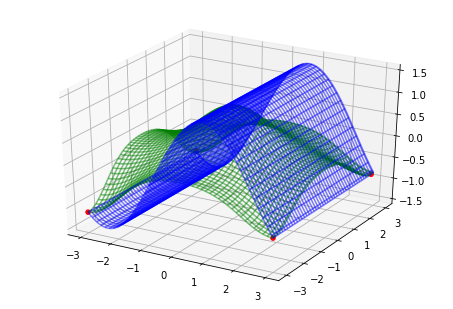

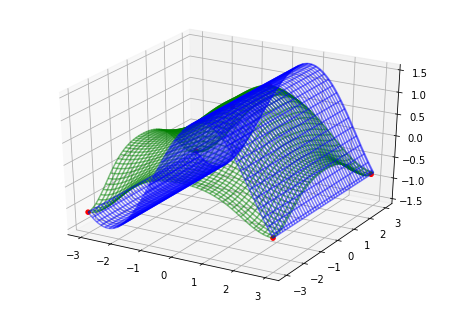

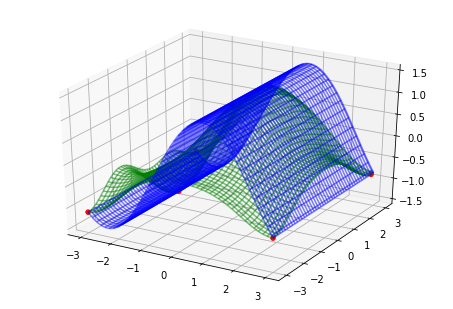

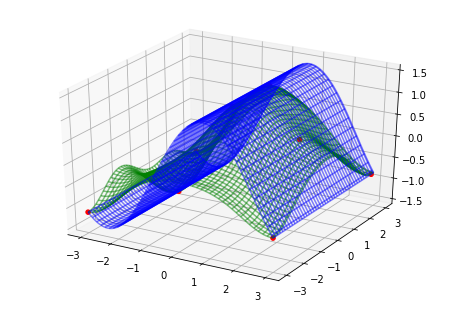

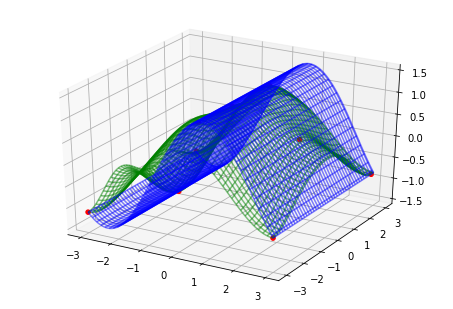

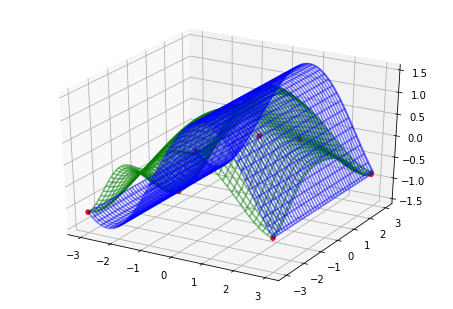

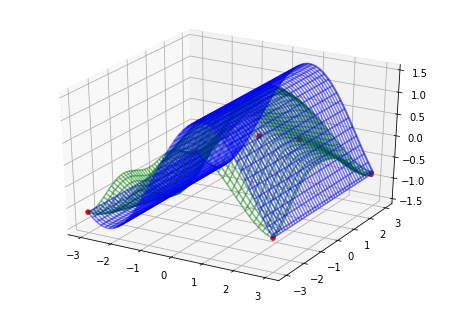

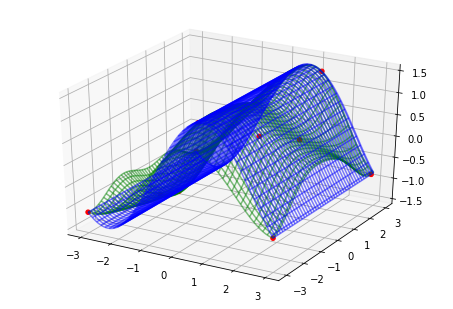

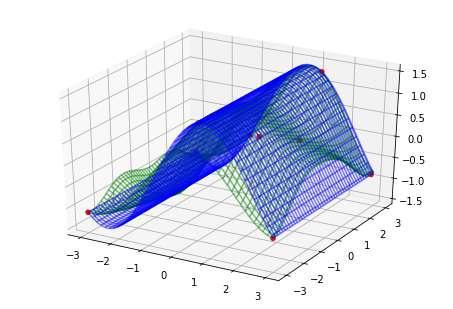

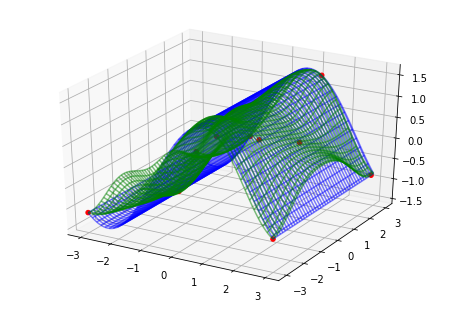

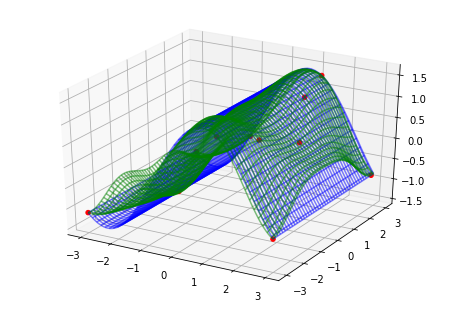

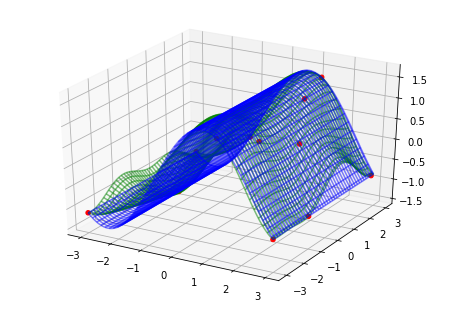

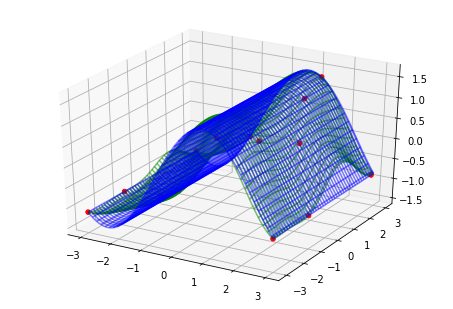

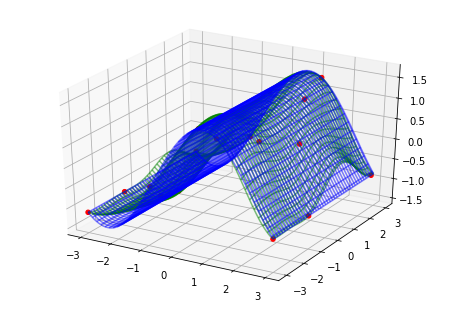

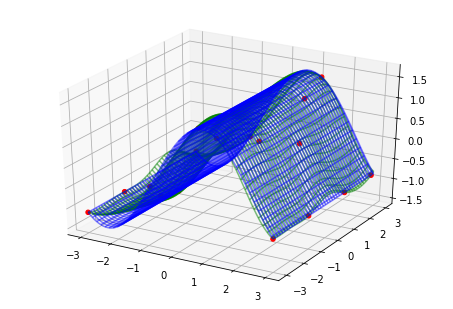

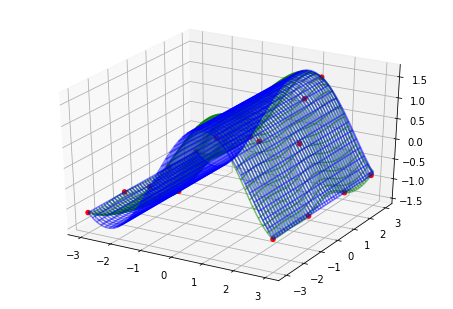

In [25]:
if __name__ == '__main__':
  class DummyEnvironment(object):
    def sample(self, x):
      return np.sin(x[0])+np.cos(x[0])

  x = np.arange(-3, 3, 0.023)
  y = np.arange(-3, 3, 0.023)
  env = DummyEnvironment()
  agent = GPUCB(np.meshgrid(x, y), env)
  for i in range(20):
    agent.learn()
    agent.plot()

In [5]:
env